In [1]:
import numpy as np
import matplotlib.pyplot as plt
import rosbag
import rospy
# !pip install basemap gmplot
from mpl_toolkits.basemap import Basemap
from gmplot import gmplot
import os

In [2]:
def geodetic_to_ecef(longtitude, latitude, altitude):
    kSemimajorAxis = 6378137.0
    # kSemiminorAxis = 6356752.3142
    kFirstEccentricitySquared = 6.69437999014 * 0.001
    # kSecondEccentricitySquared = 6.73949674228 * 0.001
    # kFlattening = 1 / 298.257223563
    lat_rad = np.radians(latitude)
    lon_rad = np.radians(longtitude)
    xi = np.sqrt(1-kFirstEccentricitySquared * np.sin(lat_rad)**2)
    x = (kSemimajorAxis / xi + altitude) * np.cos(lat_rad) * np.cos(lon_rad)
    y = (kSemimajorAxis / xi + altitude) * np.cos(lat_rad) * np.sin(lon_rad)
    z = ((1 - kFirstEccentricitySquared) * kSemimajorAxis / xi + altitude) * np.sin(lat_rad)
    return x, y, z

def n_re(lat_radians, lon_radians):
    s_lat = np.sin(lat_radians)
    s_lon = np.sin(lon_radians)
    c_lat = np.cos(lat_radians)
    c_lon = np.cos(lon_radians)

    ret = np.zeros((3,3))
    ret[0, 0] = -s_lat * c_lon
    ret[0, 1] = -s_lat * s_lon
    ret[0, 2] = c_lat
    ret[1, 0] = -s_lon
    ret[1, 1] = c_lon
    ret[1, 2] = 0.0
    ret[2, 0] = c_lat * c_lon
    ret[2, 1] = c_lat * s_lon
    ret[2, 2] = s_lat
    
    return ret

def ecef_to_enu(x, y, z, ecef_to_ned_matrix):
    vect = np.array([x-x[0], y-y[0], z-z[0]])
    ret = ecef_to_ned_matrix @ vect
    n, e, u = ret[0], ret[1], ret[2]
    return e, n, u

def geodetic_to_enu(longtitude, latitude, altitude):
    ecef_x0, ecef_y0, ecef_z0 = geodetic_to_ecef(longtitude[0], latitude[0], altitude[0])
    phiP = np.arctan2(ecef_z0, np.sqrt(ecef_x0**2 + ecef_y0**2)) # geodetic latitude
    ecef_to_ned_matrix = n_re(phiP, np.radians(longtitude[0]))
    
    ecef_x, ecef_y, ecef_z = geodetic_to_ecef(longtitude, latitude, altitude)
    E, N, U = ecef_to_enu(ecef_x, ecef_y, ecef_z, ecef_to_ned_matrix)
    return E, N, U


# ecef_x0, ecef_y0, ecef_z0 = geodetic_to_ecef(x[0], y[0], z[0])
# phiP = np.arctan2(ecef_z0, np.sqrt(ecef_x0**2 + ecef_y0**2)) # geodetic latitude
# ecef_to_ned_matrix = n_re(phiP, np.radians(x[0]))

# ecef_x, ecef_y, ecef_z = geodetic_to_ecef(x, y, z)
# E, N, U = ecef_to_enu(ecef_x, ecef_y, ecef_z, ecef_to_ned_matrix)

# gps_map_data = np.stack((t, E, N, U, qw, qx, qy, qz), axis=1)
# plot_gps(gps_map_data)

# np.savetxt('/media/jonathan/SamsungSSD/tro_data/husky/northwood_success_gps.txt', gps_map_data, delimiter=' ')

In [39]:
def read_gps(bag, topic_name):
    gps_data = []
    for topic, msg, t in bag.read_messages(topics=[topic_name]):
        gps_data.append([t.to_sec(), msg.longitude, msg.latitude, msg.altitude])

    gps_data = np.array(gps_data)
    freq = (gps_data.shape[0] - 1) / (gps_data[-1, 0] - gps_data[0, 0])
    E, N, U = geodetic_to_enu(gps_data[:, 1], gps_data[:, 2], gps_data[:, 3])
    t = gps_data[:, 0]
    ENU_data = np.stack((t, E, N, U), axis=1)
    ENU_data[:, 1:] = ENU_data[:, 1:] - ENU_data[0, 1:]
    print('GPS shape: ', ENU_data.shape, "freq: ", freq)
    return ENU_data

def read_pose(bag_name, topic_name):
    pose_data = []
    for topic, msg, t in bag.read_messages(topics=[topic_name]):
        pose_data.append([t.to_sec(), msg.pose.pose.position.x, msg.pose.pose.position.y, msg.pose.pose.position.z])
    pose_data = np.array(pose_data)
    
    pose_data[:, 1:] = pose_data[:, 1:] - pose_data[0, 1:]
    freq = (pose_data.shape[0] - 1) / (pose_data[-1, 0] - pose_data[0, 0])
    
    print('pose data shape: ', pose_data.shape)
    print('gps data frequency: ', freq)
    return pose_data
    
def plot_gps(gps_data, topic_name="gps"):
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle(topic_name, fontsize=16)
    colormap = plt.cm.get_cmap('viridis')
    ax = fig.add_subplot(131)
    ax.scatter(gps_data[:, 1], gps_data[:, 2], c=gps_data[:,0], cmap=colormap, marker='.')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('y (m)')
    ax.set_title('xy plane')
    ax.set_aspect('equal', 'box')
    
    ax = fig.add_subplot(132)
    ax.scatter(gps_data[:, 1], gps_data[:, 3], c=gps_data[:,0], cmap=colormap, marker='.')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('z (m)')
    ax.set_title('xz plane')

    ax = fig.add_subplot(133)
    ax.scatter(gps_data[:, 2], gps_data[:, 3], c=gps_data[:,0], cmap=colormap, marker='.')
    ax.set_xlabel('y (m)')
    ax.set_ylabel('z (m)')
    ax.set_title('yz plane')
    
def save_pose_to_tum(data, filename='gps.txt'):
    t = data[:, 0]
    x = data[:, 1]
    y = data[:, 2]
    z = data[:, 3]
    qw = np.ones(t.shape[0])
    qx = np.zeros(t.shape[0])
    qy = np.zeros(t.shape[0])
    qz = np.zeros(t.shape[0])
    tum_data = np.stack((t, x, y, z, qx, qy, qz, qw), axis=1)

    # save to txt file
    np.savetxt(filename, tum_data, delimiter=' ')
    
def gps_to_tum(gps_data):
    t = gps_data[:, 0]
    x = gps_data[:, 1]
    y = gps_data[:, 2]
    z = gps_data[:, 3]
    qw = np.ones(t.shape[0])
    qx = np.zeros(t.shape[0])
    qy = np.zeros(t.shape[0])
    qz = np.zeros(t.shape[0])
    return np.stack((t, x, y, z, qx, qy, qz, qw), axis=1)

def gps_to_vel(gps_data):
    t = gps_data[:, 0]
    x = gps_data[:, 1]
    y = gps_data[:, 2]
    z = gps_data[:, 3]
    vx = np.gradient(x, t)
    vy = np.gradient(y, t)
    vz = np.gradient(z, t)
    return np.stack((t, vx, vy, vz), axis=1)

def save_vel(vel_data, filename="vel.txt"):
    np.savetxt(filename, vel_data, delimiter=' ')

In [36]:
# bag = rosbag.Bag('/media/jonathan/SamsungSSD/tro_data/husky/northwood_success.bag')
# topic_name = '/gps/fix'

# gps_data = []
# for topic, msg, t in bag.read_messages(topics=[topic_name]):
#     gps_data.append([t.to_sec(), msg.longitude, msg.latitude, msg.altitude])

# gps_data = np.array(gps_data)
# freq = (gps_data.shape[0] - 1) / (gps_data[-1, 0] - gps_data[0, 0])

# print('gps data shape: ', gps_data.shape)
# print('gps data frequency: ', freq)
# plot_gps(gps_data)


# # write gps_data to txt file according to tum format
# t = gps_data[:, 0]
# x = gps_data[:, 1]
# y = gps_data[:, 2]
# z = gps_data[:, 3]
# qw = np.ones(t.shape[0])
# qx = np.zeros(t.shape[0])
# qy = np.zeros(t.shape[0])
# qz = np.zeros(t.shape[0])

In [38]:
##### for TRO neya GPS gt generation #####
root_path = "/media/jonathan/SamsungSSD/tro_data/neya/neya_data/"
directory_name = ["paintball", "pelenor"]
directory_names = [root_path+_ for _ in directory_name]

topic_name = '/mrzr/localization/piksi_attitude/navsatfix_spp'

for dir_name in directory_names:
   for filename in os.listdir(dir_name):
      if filename.endswith(".bag"):
         short_filename = filename.split("_general")[0]
         print("Processing: "+short_filename+" "+dir_name+"/"+filename)
         if not os.path.exists(root_path+"/result/"+short_filename):
            os.makedirs(root_path+"/result/"+short_filename)
         bag = rosbag.Bag(dir_name+"/"+filename)
         gps_data = read_gps(bag, topic_name)
         tum_data = gps_to_tum(gps_data)
         vel_data = gps_to_vel(gps_data)
         save_vel(vel_data, root_path+"/result/"+short_filename+"/velocity.txt")
         save_pose_to_tum(tum_data, root_path+"/result/"+short_filename+"/gps.txt")

##########################################

Processing: follow /media/jonathan/SamsungSSD/tro_data/neya/neya_data/paintball/follow_general_2022-12-01-15-44-43_0.bag
GPS shape:  (1434, 4) freq:  4.503449396307112
(1434,) (1434,)
Processing: hill_loop_dynamic /media/jonathan/SamsungSSD/tro_data/neya/neya_data/paintball/hill_loop_dynamic_general_2022-12-01-16-10-10_0.bag
GPS shape:  (673, 4) freq:  5.000528058896829
(673,) (673,)
Processing: hill_loop /media/jonathan/SamsungSSD/tro_data/neya/neya_data/paintball/hill_loop_general_2022-12-01-15-30-02_0.bag
GPS shape:  (805, 4) freq:  5.000016963658072
(805,) (805,)
Processing: leader_follow_2 /media/jonathan/SamsungSSD/tro_data/neya/neya_data/paintball/leader_follow_2_general_2022-12-01-16-02-59_0.bag
GPS shape:  (618, 4) freq:  4.919472792222006
(618,) (618,)
Processing: leader_follow /media/jonathan/SamsungSSD/tro_data/neya/neya_data/paintball/leader_follow_general_2022-12-01-15-54-24_0.bag
GPS shape:  (1960, 4) freq:  4.597762673717481
(1960,) (1960,)
Processing: long_dynamic /med

gps data shape:  (1904, 4)
gps data frequency:  4.462984202038595
gps data shape:  (1960, 4)
gps data frequency:  4.597758032468632
gps data shape:  (1903, 4)
gps data frequency:  4.462821739770914
gps data shape:  (1960, 4)
gps data frequency:  4.597762673717481


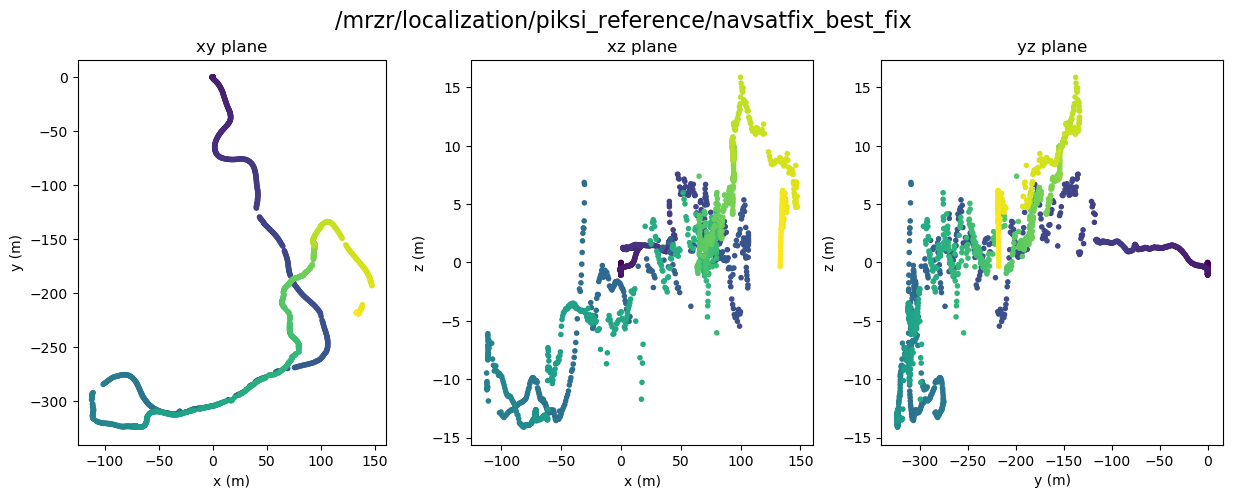

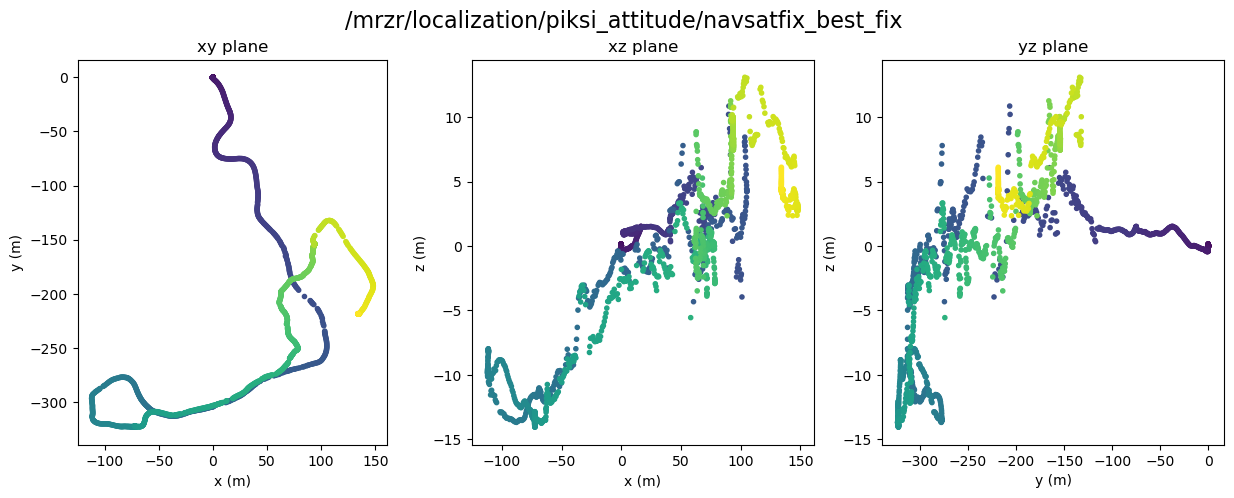

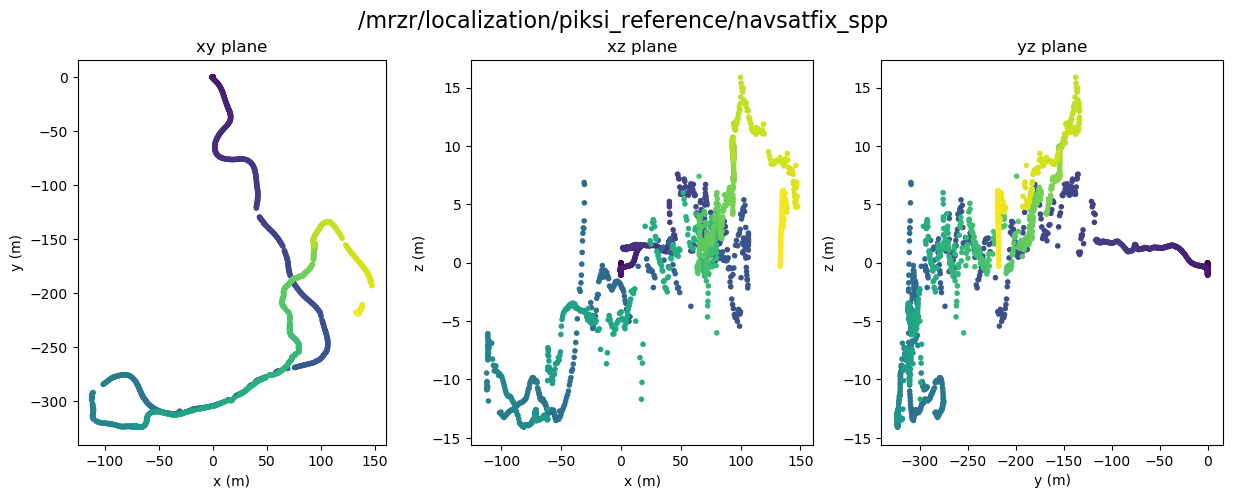

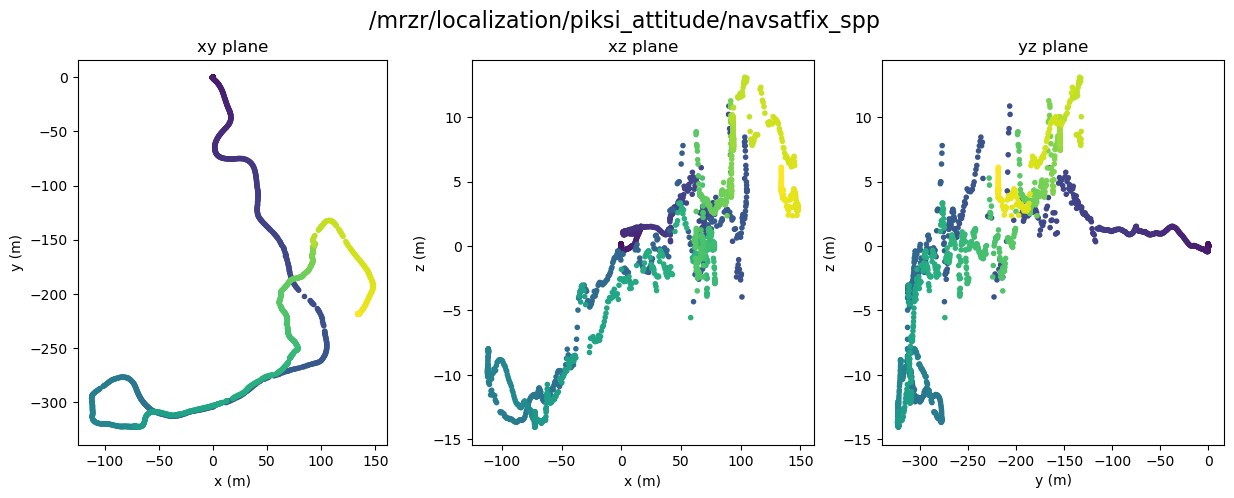

In [29]:
# bag, bag_name = rosbag.Bag('./follow_general_2022-12-01-15-44-43_0.bag'), 'follow'

# bag, bag_name = rosbag.Bag('/media/jonathan/SamsungSSD/tro_data/neya/neya_data/pelenor/low_speed_loop_general_2022-12-01-10-09-04_0.bag'), 'low-speed'
# bag, bag_name = rosbag.Bag('/media/jonathan/SamsungSSD/tro_data/neya/neya_data/pelenor/high_speed_loop_general_2022-12-01-10-12-17_0.bag'), 'high-speed'
# bag, bag_name = rosbag.Bag('./pelenor/figure_eight_1_general_2022-12-01-11-13-02_0.bag'), 'eight'
# bag, bag_name = rosbag.Bag('./pelenor/doughnut_1_general_2022-12-01-10-16-39_0.bag'), 'dounut'

bag, bag_name = rosbag.Bag('/media/jonathan/SamsungSSD/tro_data/neya/neya_data/paintball/leader_follow_general_2022-12-01-15-54-24_0.bag'), 'leader-follow'
# bag, bag_name = rosbag.Bag('./paintball/long_run_1_general_2022-12-01-14-58-21_0.bag'), 'long-run'



if not os.path.exists('/home/jonathan/tro/neya/'+bag_name+'/'):
   os.makedirs('/home/jonathan/tro/neya/'+bag_name+'/')
   print('Created directory: ' + '/home/jonathan/tro/neya/'+bag_name+'/')
   
# plot 4 different gps topics
topic_name = '/mrzr/localization/piksi_reference/navsatfix_best_fix'
gps_data = read_gps(bag, topic_name)
plot_gps(gps_data, topic_name)
data = gps_to_tum(gps_data)
save_pose_to_tum(data, '/home/jonathan/tro/neya/'+bag_name+'/gps_reference_navsatfix_best_fix-'+bag_name+'.txt')

topic_name = '/mrzr/localization/piksi_attitude/navsatfix_best_fix'
gps_data = read_gps(bag, topic_name)
plot_gps(gps_data, topic_name)
data = gps_to_tum(gps_data)
save_pose_to_tum(data, '/home/jonathan/tro/neya/'+bag_name+'/gps_attitude_navsatfix_best_fix-'+bag_name+'.txt')

topic_name = '/mrzr/localization/piksi_reference/navsatfix_spp'
gps_data = read_gps(bag, topic_name)
plot_gps(gps_data, topic_name)
data = gps_to_tum(gps_data)
save_pose_to_tum(data, '/home/jonathan/tro/neya/'+bag_name+'/gps_reference_navsatfix_spp-'+bag_name+'.txt')

topic_name = '/mrzr/localization/piksi_attitude/navsatfix_spp'
gps_data = read_gps(bag, topic_name)
plot_gps(gps_data, topic_name)
data = gps_to_tum(gps_data)
save_pose_to_tum(data, '/home/jonathan/tro/neya/'+bag_name+'/gps_attitude_navsatfix_spp-'+bag_name+'.txt')

In [ ]:
bag = rosbag.Bag('/media/jonathan/SamsungSSD/tro_data/neya/neya_data/pelenor_evening/second_pelennor_1_general_2022-11-29-16-40-07_0.bag')
gps_data = read_gps(bag, topic_name)
pose_data = read_pose(bag, '/mrzr/localization/piksi_reference/enu_pose_spp')
plot_gps(gps_data)
plot_gps(pose_data)